In [2]:
!pip install gymnasium[atari]
!pip install ale-py
!pip install gymnasium[accept-rom-license]

In [4]:
import gymnasium as gym
import ale_py
import torch

# Check GPU
print("GPU available:", torch.cuda.is_available())

# Register and test
gym.register_envs(ale_py)
env = gym.make('ALE/BasicMath-v5')

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

obs, info = env.reset()
print("Observation shape:", obs.shape)
env.close()

GPU available: True
Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(6)
Observation shape: (210, 160, 3)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# DQN Network - FIXED for BasicMath dimensions
class DQN(nn.Module):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # Calculate correct input size dynamically
        self.fc_input_size = self._get_conv_output((3, 210, 160))
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, action_size)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            return int(np.prod(x.size()))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# Preprocess frame
def preprocess_frame(frame):
    frame = torch.from_numpy(frame).float()
    frame = frame.permute(2, 0, 1)  # HWC to CHW
    frame = frame / 255.0
    return frame.unsqueeze(0)

print("DQN classes defined - FIXED!")

DQN classes defined - FIXED!


In [6]:
def train_dqn(total_episodes=1000, learning_rate=0.0001, gamma=0.99,
              epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
              batch_size=32, buffer_size=10000):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make('ALE/BasicMath-v5')

    action_size = env.action_space.n
    policy_net = DQN(action_size).to(device)
    target_net = DQN(action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(buffer_size)

    episode_rewards = []
    episode_lengths = []
    losses = []

    for episode in range(total_episodes):
        state, _ = env.reset()
        state = preprocess_frame(state).to(device)
        total_reward = 0
        steps = 0

        while steps < 99:  # max_steps
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = policy_net(state).argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess_frame(next_state).to(device)

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps += 1

            # Training
            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.cat(states).to(device)
                next_states = torch.cat(next_states).to(device)
                actions = torch.tensor(actions).to(device)
                rewards = torch.tensor(rewards).float().to(device)
                dones = torch.tensor(dones).float().to(device)

                current_q = policy_net(states).gather(1, actions.unsqueeze(1))
                next_q = target_net(next_states).max(1)[0].detach()
                target_q = rewards + (gamma * next_q * (1 - dones))

                loss = nn.MSELoss()(current_q.squeeze(), target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            if done:
                break

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % 50 == 0:
            print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}, Avg Steps: {np.mean(episode_lengths[-50:]):.1f}")

        if episode % 100 == 0:
            target_net.load_state_dict(policy_net.state_dict())

    env.close()
    return episode_rewards, episode_lengths, losses

print("Training function ready!")

Training function ready!


Starting baseline training...
Episode 0, Reward: 0.00, Epsilon: 0.995, Avg Steps: 99.0
Episode 50, Reward: 0.00, Epsilon: 0.774, Avg Steps: 99.0
Episode 100, Reward: 0.00, Epsilon: 0.603, Avg Steps: 99.0
Episode 150, Reward: 0.00, Epsilon: 0.469, Avg Steps: 99.0
Episode 200, Reward: 0.00, Epsilon: 0.365, Avg Steps: 99.0
Episode 250, Reward: 0.00, Epsilon: 0.284, Avg Steps: 99.0
Episode 300, Reward: 1.00, Epsilon: 0.221, Avg Steps: 99.0
Episode 350, Reward: 0.00, Epsilon: 0.172, Avg Steps: 99.0
Episode 400, Reward: 0.00, Epsilon: 0.134, Avg Steps: 99.0
Episode 450, Reward: 0.00, Epsilon: 0.104, Avg Steps: 99.0
Episode 500, Reward: 1.00, Epsilon: 0.081, Avg Steps: 99.0
Episode 550, Reward: 0.00, Epsilon: 0.063, Avg Steps: 99.0
Episode 600, Reward: 0.00, Epsilon: 0.049, Avg Steps: 99.0
Episode 650, Reward: 0.00, Epsilon: 0.038, Avg Steps: 99.0
Episode 700, Reward: 0.00, Epsilon: 0.030, Avg Steps: 99.0
Episode 750, Reward: 0.00, Epsilon: 0.023, Avg Steps: 99.0


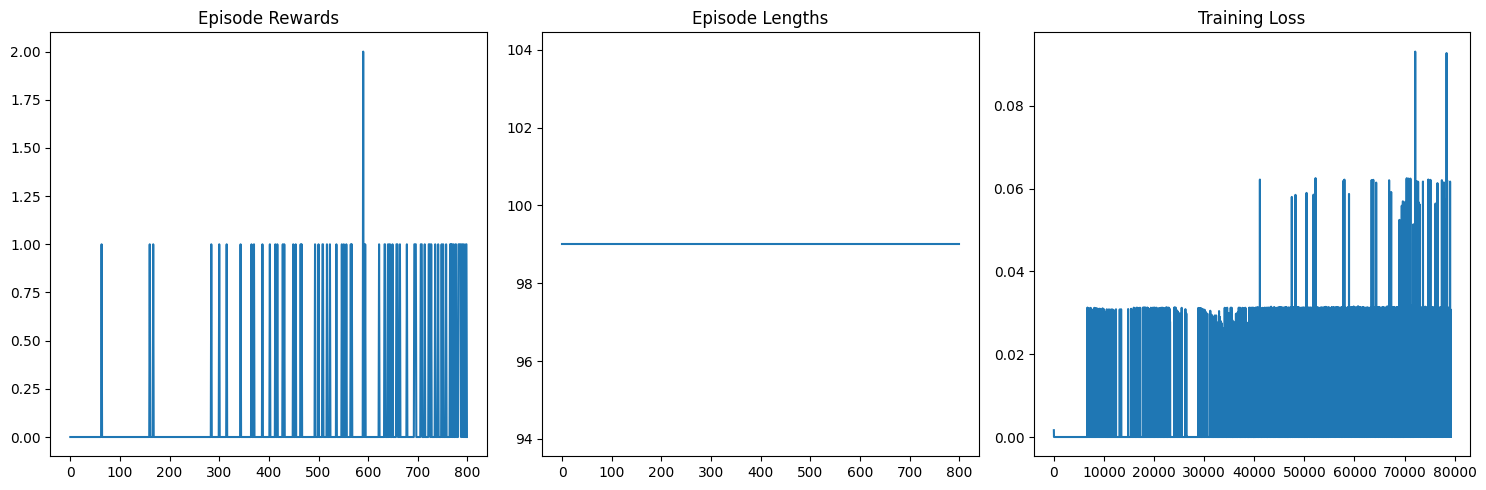

Baseline complete! Avg reward: 0.29


In [12]:
print("Starting baseline training...")
rewards, lengths, losses = train_dqn(
    total_episodes=800,
    learning_rate=0.0001,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.subplot(1, 3, 2)
plt.plot(lengths)
plt.title('Episode Lengths')
plt.subplot(1, 3, 3)
plt.plot(losses)
plt.title('Training Loss')
plt.tight_layout()
plt.show()

print(f"Baseline complete! Avg reward: {np.mean(rewards[-100:]):.2f}")

In [13]:
# Run after baseline completes
print("Experiment 1: Gamma=0.8")
rewards_g8, lengths_g8, losses_g8 = train_dqn(
    total_episodes=500,
    learning_rate=0.0001,
    gamma=0.8,  # Changed from 0.99
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)
print(f"Gamma=0.8 Avg reward: {np.mean(rewards_g8[-100:]):.2f}")

Experiment 1: Gamma=0.8
Episode 0, Reward: 0.00, Epsilon: 0.995, Avg Steps: 99.0
Episode 50, Reward: 0.00, Epsilon: 0.774, Avg Steps: 99.0
Episode 100, Reward: 0.00, Epsilon: 0.603, Avg Steps: 99.0
Episode 150, Reward: 0.00, Epsilon: 0.469, Avg Steps: 99.0
Episode 200, Reward: 0.00, Epsilon: 0.365, Avg Steps: 99.0
Episode 250, Reward: 0.00, Epsilon: 0.284, Avg Steps: 99.0
Episode 300, Reward: 0.00, Epsilon: 0.221, Avg Steps: 99.0
Episode 350, Reward: 0.00, Epsilon: 0.172, Avg Steps: 99.0
Episode 400, Reward: 0.00, Epsilon: 0.134, Avg Steps: 99.0
Episode 450, Reward: 0.00, Epsilon: 0.104, Avg Steps: 99.0
Gamma=0.8 Avg reward: 0.00


Experiment 2: LR=0.001
Episode 0, Reward: 0.00, Epsilon: 0.995, Avg Steps: 99.0
Episode 50, Reward: 0.00, Epsilon: 0.774, Avg Steps: 99.0
Episode 100, Reward: 0.00, Epsilon: 0.603, Avg Steps: 99.0
Episode 150, Reward: 0.00, Epsilon: 0.469, Avg Steps: 99.0
Episode 200, Reward: 0.00, Epsilon: 0.365, Avg Steps: 99.0
Episode 250, Reward: 0.00, Epsilon: 0.284, Avg Steps: 99.0
Episode 300, Reward: 0.00, Epsilon: 0.221, Avg Steps: 99.0
Episode 350, Reward: 0.00, Epsilon: 0.172, Avg Steps: 99.0
Episode 400, Reward: 0.00, Epsilon: 0.134, Avg Steps: 99.0
Episode 450, Reward: 0.00, Epsilon: 0.104, Avg Steps: 99.0


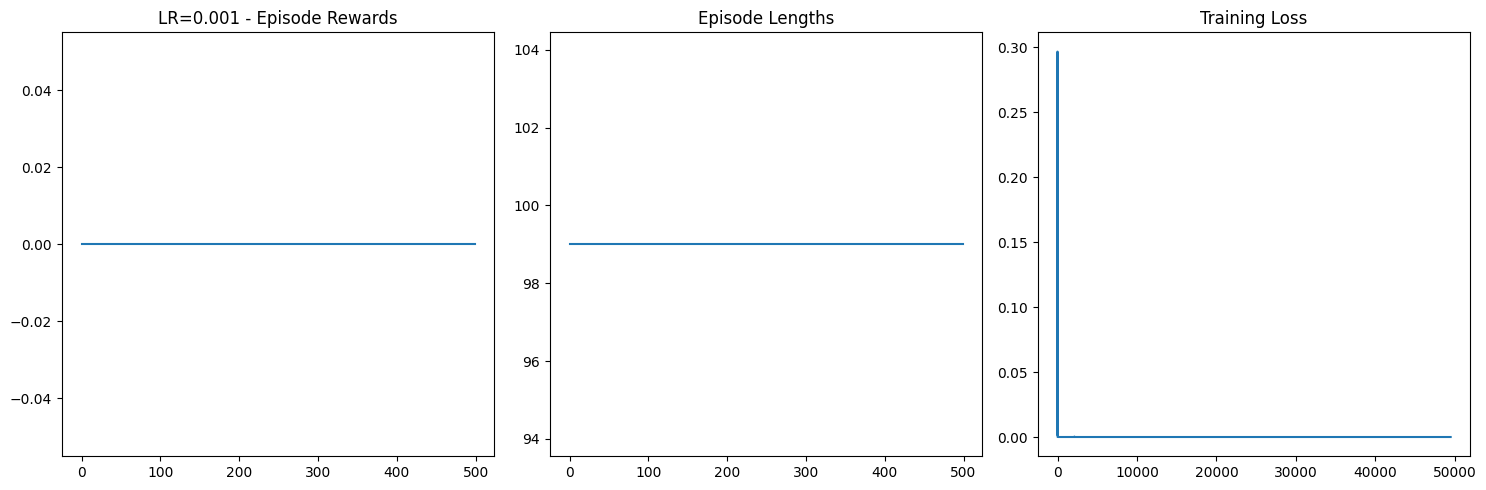

LR=0.001 Avg reward: 0.00


In [14]:
print("Experiment 2: LR=0.001")
rewards_lr, lengths_lr, losses_lr = train_dqn(
    total_episodes=500,
    learning_rate=0.001,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(rewards_lr)
plt.title('LR=0.001 - Episode Rewards')
plt.subplot(1, 3, 2)
plt.plot(lengths_lr)
plt.title('Episode Lengths')
plt.subplot(1, 3, 3)
plt.plot(losses_lr)
plt.title('Training Loss')
plt.tight_layout()
plt.show()
print(f"LR=0.001 Avg reward: {np.mean(rewards_lr[-100:]):.2f}")

Experiment 3: Faster decay=0.98
Episode 0, Reward: 0.00, Epsilon: 0.980, Avg Steps: 99.0
Episode 50, Reward: 0.00, Epsilon: 0.357, Avg Steps: 99.0
Episode 100, Reward: 0.00, Epsilon: 0.130, Avg Steps: 99.0
Episode 150, Reward: 0.00, Epsilon: 0.047, Avg Steps: 99.0
Episode 200, Reward: 0.00, Epsilon: 0.017, Avg Steps: 99.0
Episode 250, Reward: 0.00, Epsilon: 0.010, Avg Steps: 99.0
Episode 300, Reward: 0.00, Epsilon: 0.010, Avg Steps: 99.0
Episode 350, Reward: 0.00, Epsilon: 0.010, Avg Steps: 99.0
Episode 400, Reward: 0.00, Epsilon: 0.010, Avg Steps: 99.0
Episode 450, Reward: 0.00, Epsilon: 0.010, Avg Steps: 99.0


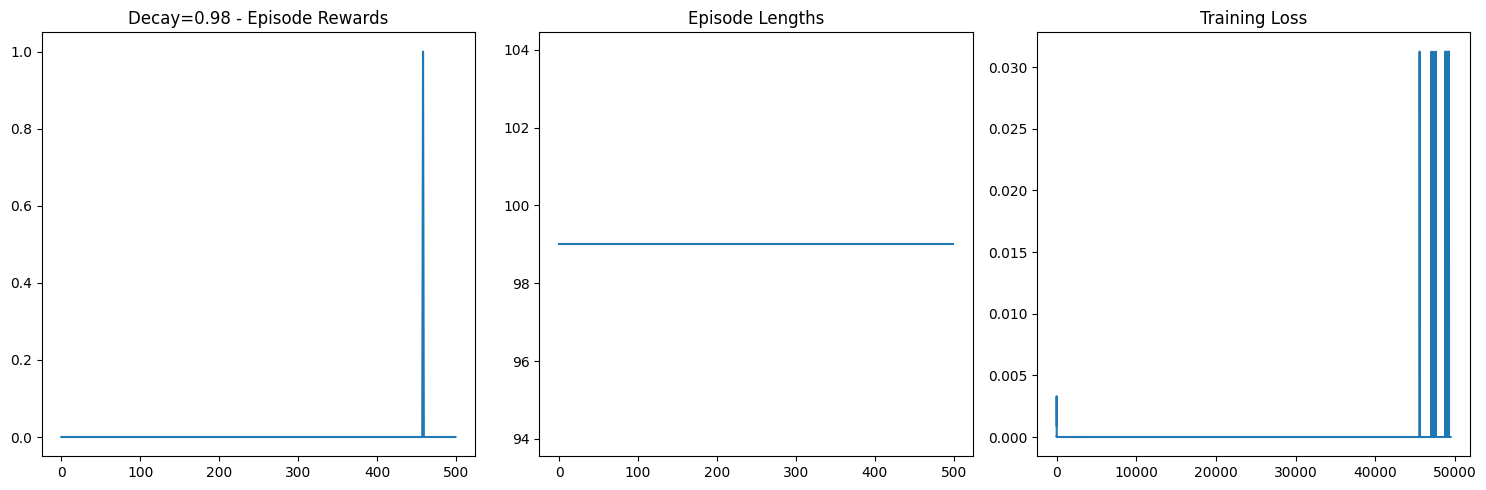

Decay=0.98 Avg reward: 0.01


In [7]:
print("Experiment 3: Faster decay=0.98")
rewards_eps, lengths_eps, losses_eps = train_dqn(
    total_episodes=500,
    learning_rate=0.0001,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.98
)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(rewards_eps)
plt.title('Decay=0.98 - Episode Rewards')
plt.subplot(1, 3, 2)
plt.plot(lengths_eps)
plt.title('Episode Lengths')
plt.subplot(1, 3, 3)
plt.plot(losses_eps)
plt.title('Training Loss')
plt.tight_layout()
plt.show()
print(f"Decay=0.98 Avg reward: {np.mean(rewards_eps[-100:]):.2f}")